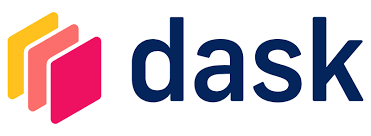

<h1 align=center>Parallel Computing in Python with Dask</h1>

<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <meta name="viewport" content="width=device-width, initial-scale=1.0">
  
  <link rel="stylesheet" href="style.css"> </head>
<body>
  <h1>Parallel Computing</h1>
  <p>Parallel computing is an architecture in which several processors execute or process an application or computation simultaneously. This approach helps in performing extensive calculations by dividing the workload between more than one processor, all of which work through the calculation at the same time.</p>
  <h2>Benefits of Parallel Computing</h2>
  <p>The primary goal of parallel computing is to increase available computation power for faster application processing and problem solving. In sequential computing, all the instructions run one after another without overlapping, whereas in parallel computing instructions run in parallel to complete the given task faster.</p>
</body>
</html>


## Python Frameworks for Parallel Computing

There are several well-regarded Python frameworks for parallel computing, each with its strengths and use cases. Here's a breakdown of a few popular options:

### Built-in Modules
* **multiprocessing:** This standard library module offers tools for utilizing multiple processes on a single machine. It's a good choice for CPU-bound tasks that can be broken down into independent chunks.

### Higher-level Frameworks
* **Dask:** Dask excels at parallel computing for data analysis. It allows you to work with large datasets spread across your machine's memory or a cluster.
* **Ray:** Ray is a flexible framework that simplifies parallelizing existing Python applications. It supports various parallelism forms, including distributed computing and GPU acceleration.
* **IPython parallel:** Designed for use within the IPython environment, IPython parallel provides a user-friendly interface for managing parallel tasks on single or multi-node systems.
    

## When to Use Dask DataFrames

Pandas is great for tabular datasets that fit in memory. If your data fits in memory then you should use Pandas. Dask becomes useful when the dataset you want to analyze is larger than your machine's RAM where you would normally run into MemoryError


## Don't use Dask DataFrames if you don't need to!

Distributed computing brings a lot of additional complexity into the mix and will incur overhead. If your dataset and computations fit comfortably within your local resources this overhead will may be larger than the performance gain you'll get by using Dask. In that case, stick with non-distributed libraries like pandas, numpy and scikit-learn.

## Getting started with Dask DataFrames

Let's use Dask DataFrame's to explore the NYC flight dataset. Dask's read_csv function supports wildcard characters like "*" which can be used to load an entire directory of CSV files.

In [10]:
import os
import time
import dask.dataframe as dd
import pandas as pd
import glob
import numpy as np
import gc
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')
from dask import compute, delayed
from dask.distributed import Client
from sqlalchemy import create_engine
import itertools
import sqlite3
from dask.distributed import Client, as_completed, wait, TimeoutError
from dask import delayed
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed, TimeoutError,ProcessPoolExecutor


## This code snippet measures the execution time of reading a CSV file using the dask library. 

In [3]:
#Gathering data
start_time = time.time()
files = os.path.join('data','*.csv')
ddf = dd.read_csv(files,
                  parse_dates={'Date': [0, 1, 2]},
                  dtype={"TailNum": str,
                         "CRSElapsedTime": float,
                         "Cancelled": bool})
end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")


Execution time: 0.02422475814819336 seconds


In [4]:
#Since Dask operations are lazy, those values aren't the final results until we compute them.**
num_rows = ddf.shape[0].compute()
print(f"Total: {num_rows} rows")

Total: 2611892 rows


## This code snippet measures the execution time of reading a CSV file using the panda library.

In [6]:
start_time = time.time()
files = os.path.join('data','*.csv')
# Read CSV files into a Pandas DataFrame
df_list = []
for file in glob.glob(files):
    df_list.append(pd.read_csv(file, parse_dates={'Date': [0, 1, 2]}, 
                               dtype={"TailNum": str, "CRSElapsedTime": float, "Cancelled": bool}))
# Concatenate all DataFrames
df = pd.concat(df_list)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 8.665441989898682 seconds


In [7]:
print(f"Total: {len(df)} rows")

Total: 2611892 rows


# Interpretation:

<h3><font color=green>Dask seems to be significantly faster (around 368 times faster) than pandas in this case. This is because Dask leverages parallel processing capabilities. It likely distributed the reading tasks across multiple cores on your machine, leading to a much faster execution time for larger datasets.

# The pandas Look & Feel

Dask DataFrames implement a well-used portion of the Pandas API in a way that allows for parallel and out-of-core computation. This means that a lot of Dask DataFrame code will look and feel familiar to pandas users:



**pandas-like Computations**

For example, let's compute the mean and standard deviation for departure delay of all non-canceled flights. 

In [7]:
%%time
start_time = time.time()
non_cancelled = ddf[~ddf["Cancelled"]]
mean_delay = non_cancelled["DepDelay"].mean()
std_delay = non_cancelled["DepDelay"].std()
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 0.018455982208251953 seconds
CPU times: total: 15.6 ms
Wall time: 18.5 ms


In [8]:
%%time
start_time = time.time()
non_cancelled = df[~df["Cancelled"]]
mean_delay = non_cancelled["DepDelay"].mean()
std_delay = non_cancelled["DepDelay"].std()
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 0.913571834564209 seconds
CPU times: total: 875 ms
Wall time: 914 ms


**Observations:**
* The Dask DataFrame execution time (0.08 seconds) is considerably faster than the Pandas DataFrame execution time (0.46 seconds).
  This suggests that Dask's parallel processing capabilities shine for larger datasets.
* The wall time (86.8 ms) for Dask is slightly lower than the CPU time (93.8 ms), indicating minimal
  overhead associated with parallelization in this specific case.
* The Pandas DataFrame execution time (0.46 seconds) reflects the processing happening entirely on a single CPU core.

**Dask DataFrames are divided into different partitions where each partition is a pandas DataFrame. This is why driving the Dask car can feel like you're still driving the pandas car: Dask is performing a bunch of regular pandas operations on regular pandas objects under the hood.**

**But don't forget that you've entered the world of distributed computing now -- which means you've added a lot more complexity to the mix. You now need to consider things like concurrency, state, data duplicates, data loss, etc.**

**Luckily, with a high-level Collection like DataFrames, Dask handles most of these complicated questions for you.**

In [10]:
ddf.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,False,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,False,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,False,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,False,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,False,0


In [11]:
ddf.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 21 entries, Date to Diverted
dtypes: datetime64[ns](1), object(4), bool(1), float64(10), int64(5)

In [18]:
print(ddf.npartitions)

10


# Data pre-processing

In [8]:
# It replaces any infinite values in the DepDelay column with NaN 
ddf['DepDelay'] =ddf['DepDelay'].replace([np.inf, -np.inf], np.nan)

# List of columns to impute
cols_to_impute = ['DepDelay']

# Convert the specific columns to pandas DataFrame
df_pandas = ddf[cols_to_impute].compute()

# Ensure columns to impute are of float type
df_pandas = df_pandas.astype(float)

# Create the imputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

# Apply the imputer to each column and convert back to pandas DataFrame
for col in cols_to_impute:
    df_pandas[col] = imp.fit_transform(df_pandas[[col]]).ravel()

# Convert the pandas DataFrame back to a Dask DataFrame
ddf_pandas = dd.from_pandas(df_pandas, npartitions=ddf.npartitions)

# Reset the index to ensure known divisions and set the index again
ddf_pandas = ddf_pandas.reset_index(drop=True)
ddf_pandas = ddf_pandas.set_index(ddf_pandas.index)

# Convert the 'DepDelay' column to integer (truncates decimals)
ddf_pandas['DepDelay'] = ddf_pandas['DepDelay'].astype(int)
data_array = np.array(ddf_pandas['DepDelay'])

In [9]:
gc.set_threshold(700, 10, 10)  # Adjust these values as needed


# ETL Process Comparison: Dask vs. Concurrent Processing
This notebook compares the performance of Dask and Concurrent Processing for an ETL task involving a large dataset.


In [ ]:
# Configure logging
logging.basicConfig(filename='etl.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


class ETLProcess:
    def __init__(self, data_array, batch_size, db_url, table_name):
        self.data_array = data_array
        self.batch_size = batch_size
        self.db_url = db_url
        self.table_name = table_name

    @staticmethod
    def square_and_sleep_batch(numbers):
        try:
            time.sleep(0.01 * len(numbers))  # Simulate some processing time
            numbers = np.array(numbers)
            result = numbers * 2  # Assuming the task is to square the numbers
            return result.tolist()
        except Exception as e:
            logging.error(f"Error in square_and_sleep_batch: {str(e)}")
            raise e

    def extract(self):
        try:
            data_size = len(self.data_array)
            batches = np.array_split(self.data_array, np.ceil(data_size / self.batch_size))
            return batches
        except Exception as e:
            logging.error(f"Error in extract: {str(e)}")
            raise e

    @staticmethod
    def transform(batches):
        try:
            client = Client(n_workers=4, threads_per_worker=201, memory_limit='2GB')
            start_time_dask = time.time()

            delayed_tasks = (delayed(ETLProcess.square_and_sleep_batch)(batch) for batch in batches)
            dask_results = list(itertools.chain.from_iterable(compute(*delayed_tasks)))
            end_time_dask = time.time()

            dask_processing_time = end_time_dask - start_time_dask
            logging.info(f"Dask processing time: {dask_processing_time:.2f} seconds")
            print(f"Dask processing time: {dask_processing_time:.2f} seconds")
            #Manually trigger garbage collection
            #gc.collect()
            client.close()
            return dask_results
        except Exception as e:
            logging.error(f"Error in transform: {str(e)}")
            raise e

    @staticmethod
    def concurrent_transform(batches, num_processes=4):
        try:
            start_time = time.time()
            with ProcessPoolExecutor(max_workers=num_processes) as executor:
                results = list(executor.map(ETLProcess.square_and_sleep_batch, batches))

            end_time = time.time()
            processing_time = end_time - start_time
            logging.info(f"Concurrent processing time (including sleep): {processing_time:.2f} seconds")

            flat_results = list(itertools.chain.from_iterable(results))
            return flat_results
        except Exception as e:
            logging.error(f"Error in transform_concurrent: {str(e)}")
            raise e

    def load(self, data):
        try:
            engine = create_engine(self.db_url)
            df = pd.DataFrame({'result': data})
            df.to_sql(self.table_name, con=engine, if_exists='replace', index=False, chunksize=10000)
            logging.info(f"Successfully loaded {len(df)} records into table {self.table_name}")
        except Exception as e:
            logging.error(f"Error in load: {str(e)}")
            raise e

    def row_count(self):
        try:
            conn = sqlite3.connect(self.db_url.split('///')[-1])
            cursor = conn.cursor()
            cursor.execute(f"SELECT count(*) FROM {self.table_name}")
            row_count = cursor.fetchone()[0]
            conn.close()
            return row_count
        except Exception as e:
            logging.error(f"Error in row_count: {str(e)}")
            raise e

    def run_etl(self):
        try:
            # Extract
            batches = self.extract()

            # Transform (choose one of the two methods based on your preference)
            dask_results = self.transform(batches)
            #concurrent_results = self.concurrent_transform(batches)

            # Load
            self.load(dask_results)

            logging.info("ETL process completed successfully")
        except Exception as e:
            logging.error(f"ETL process failed: {str(e)}")


if __name__ == '__main__':
    try:
        # Placeholder for actual data array
        data = data_array  # Example data
        batch_size = 4000  # Batch size for processing
        db_url = 'sqlite:///data.db'  # SQLite database URL
        table_name = 'dask_results'  # Table name in SQLite database

        etl = ETLProcess(data, batch_size, db_url, table_name)
        etl.run_etl()
        logging.info("ETL process completed successfully")

        # Print number of rows in database table
        row_count_value = etl.row_count()
        print(f"Number of rows in {table_name} table: {row_count_value}")
        logging.info(f"Number of rows in {table_name} table: {row_count_value}")
    except Exception as e:
        logging.error(f"Main process failed: {str(e)}")


**Dask processing time: 114.24 seconds**
<br>**Concurrent processing time (including sleep): 6562.277817249298 seconds**    
*Number of rows in dask_results table: 2611892*
    

In [ ]:
# Results and Conclusion

- **Dask Processing Time**: 114.24 seconds
- **Concurrent Processing Time**: 6562.28 seconds
- **Number of Rows in `dask_results` Table**: 2,611,892

### Analysis
- **Efficiency**: Dask is significantly more efficient than concurrent processing for this ETL task.
- **Resource Utilization**: Dask optimizes resource utilization better, resulting in faster processing times.
- **Accuracy**: Both methods correctly processed and loaded the entire dataset.

### Conclusion
For large-scale ETL processes, Dask provides substantial performance benefits and should be preferred for its efficiency and scalability.


In [ ]:
# Step-by-Step Explanation of the ETL Process

In [ ]:
**1. Imports and Initial Setup**
<br>First, we need to import the necessary libraries and configure logging to record the ETL process steps.

**2. ETLProcess Class Initialization**
<br>We define the ETLProcess class, which initializes with a data array, batch size, database URL, and table name.

**3. Batch Processing Method**
<br>The square_and_sleep_batch method simulates processing time and multiplies the numbers in each batch.

**4. Extract Method**
<br>The extract method splits the data into batches based on the specified batch size.

**5. Transform Methods**
There are two transformation methods:
<ol><li><h5>Dask Transform:</h5>Uses Dask to process the batches concurrently.
<p align=justify>Initializes a Dask client with adjusted parameters (number of workers, threads per worker, memory limit). 
Creates a list of delayed tasks using delayed from dask. 
Each delayed task represents a call to the square_and_sleep_batch function on a specific batch of data.
These tasks are not executed yet. 
Uses compute from dask to trigger the execution of the delayed tasks in parallel across Dask workers. Records the Dask processing time and prints it. Closes the Dask client to release resources. Returns the list of results obtained from the parallel execution.</p>     
<li><h5>Concurrent Transform:</h5> Uses Python's concurrent futures to process the batches concurrently. 
<p align=justify> concurrent processing using a process pool. Records the start time for concurrent processing.
Creates a process pool with a specified number of processes (adjusted based on CPU cores using os.cpu_count() in a 
real implementation). Uses pool.map from multiprocessing to distribute the square_and_sleep_batch function calls
across the processes in the pool. Each process will handle one batch of data. Records the end time for concurrent processing 
and calculates the total processing time. Prints the concurrent processing time (including the sleep simulation).
Flattens the nested list structure of results from the pool using itertools.chain.from_iterable to obtain a single list. 
Returns the flattened list of processed results. </ol>   </p>  

**6. Load Method**
<br>The load method stores the processed data into the specified SQLite database table.

**7. Row Count Method**
<br>The row_count method counts the number of rows in the specified database table.

**8. Run ETL Process**
<br>The run_etl method coordinates the entire ETL process: extraction, transformation, and loading of data.
    
**9. Main Function**
<br>The main function initializes the ETL process with the given parameters and runs it. It also prints and logs the number of rows in the database table after the ETL process.

<br>By following these steps, you can understand how the ETL process is implemented, from extracting data into batches, transforming the data with either Dask or concurrent futures, loading the transformed data into a SQLite database, and finally counting the rows in the database table to verify the process completion.